# EMBER Dataset Analysis with Matrix Product States

This notebook analyzes the EMBER malware dataset using Matrix Product States (MPS), treating the malware/benign label as an additional feature in the ioint distribution.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from lib.UnsupGenModbyMPS.MPScumulant import MPS_c


## Data Loading and Preprocessing

In [ ]:
#L oad the data with first row as header
#TODO BENNY import dataset
# data = pd.read_csv('./Datasets/selected_features_mf.csv')

n_samples = 200
# Take first 1000 datapoints
data = data.iloc[:n_samples]

# Store feature names
feature_names = data.columns.tolist()

# Convert data to numpy array (excluding header)
X = data.values.astype(np.float32)

# Print basic information about the dataset
print(f"Dataset shape: {X.shape}")
print(f"Number of features: {X.shape[1]}")
print(f"Number of samples: {X.shape[0]}")
print("\nFeature names:")
for i, name in enumerate(feature_names):
    print(f"{i:2d}: {name}")
print("\nSample of first 5 rows:")
print(X[:5])

NameError: name 'data' is not defined

## Train MPS Model

bond: 0
bond: 1
bond: 2
bond: 3
bond: 4
bond: 5
bond: 6
bond: 7
bond: 8
bond: 9
bond: 9
Bondim 2->2
bond: 8
Bondim 2->3
bond: 7
Bondim 2->4
bond: 6
Bondim 2->4
bond: 5
Bondim 2->4
bond: 4
Bondim 2->4
bond: 3
Bondim 2->4
bond: 2
Bondim 2->4
bond: 1
Bondim 2->3
Current loss: 3.0666172035825126
bond: 0
Bondim 2->2
bond: 1
Bondim 3->3
bond: 2
Bondim 4->4
bond: 3
Bondim 4->5
bond: 4
Bondim 4->6
bond: 5
Bondim 4->8
bond: 6
Bondim 4->7
bond: 7
Bondim 4->5
bond: 8
Bondim 3->4
Current loss: 2.835708573597038
Current Loss: 2.835708574
Bondim:
[2 3 4 5 6 8 7 5 4 2 1]
bond: 9
Bondim 2->2
bond: 8
Bondim 4->4
bond: 7
Bondim 5->6
bond: 6
Bondim 7->8
bond: 5
Bondim 8->9
bond: 4
Bondim 6->8
bond: 3
Bondim 5->5
bond: 2
Bondim 4->4
bond: 1
Bondim 3->3
Current loss: 2.8011234199646515
bond: 0
Bondim 2->2
bond: 1
Bondim 3->2
bond: 2
Bondim 4->3
bond: 3
Bondim 5->5
bond: 4
Bondim 8->8
bond: 5
Bondim 9->8
bond: 6
Bondim 8->8
bond: 7
Bondim 6->6
bond: 8
Bondim 4->4
Current loss: 2.7990500787638974
Current Los

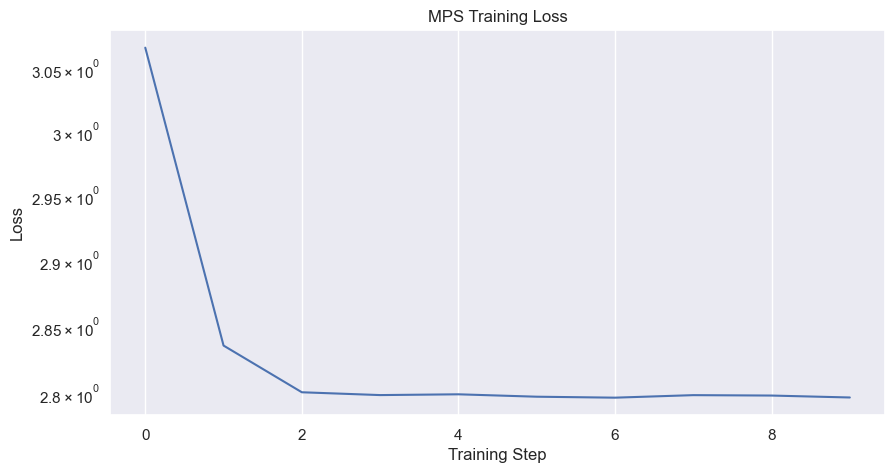

In [5]:
# Initialize MPS
n_features = X.shape[1]
mps = MPS_c(space_size=n_features)

# Configure training with more conservative parameters
mps.cutoff = 0.001  # Reduced from 0.01
mps.descenting_step_length = 0.01  # Reduced from 0.1
mps.descent_steps = 20  # Increased from 10
mps.nbatch = 20  # Increased from 5 (smaller batches)

# Train
mps.designate_data(X)
mps.left_cano()
mps.init_cumulants()
n_epochs = 5 # Reduced from 5

# Train with error handling
try:
    mps.train(n_epochs)
except Exception as e:
    print(f"Training failed with error: {str(e)}")
    print("Try adiusting batch size or learning rate")

# Plot training loss if available
if hasattr(mps, 'Loss') and len(mps.Loss) > 0:
    plt.figure(figsize=(10, 5))
    plt.plot(mps.Loss)
    plt.title('MPS Training Loss')
    plt.xlabel('Training Step')
    plt.ylabel('Loss')
    plt.yscale('log')
    plt.grid(True)
    plt.show()

## Analyze MPS Structure

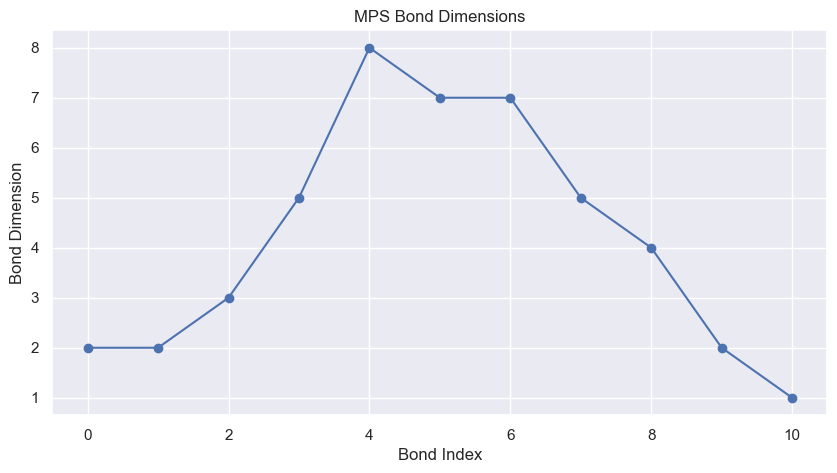

Total number of elements in dataset: 2200
Total number of elements in all tensors: 940
Compression percentage: 57.27%


In [7]:
# Plot bond dimensions
plt.figure(figsize=(10, 5))
plt.plot(mps.bond_dimension, 'o-')
plt.title('MPS Bond Dimensions')
plt.xlabel('Bond Index')
plt.ylabel('Bond Dimension')
plt.grid(True)
plt.show()

def total_tensor_elements_from_bond_dimensions(bond_dimensions):
    """Calculate the total number of elements in all tensors based on bond dimensions."""
    total_elements = 0
    for i in range(len(bond_dimensions) - 1):
        total_elements += bond_dimensions[i] * bond_dimensions[i + 1] 
    return total_elements * 2 * 2  # Multiply by 2 for complex numbers and 2 for physical dimension
                                    # Assuming physical dimension is 2 (for binary features)

# Example usage
total_elements = total_tensor_elements_from_bond_dimensions(mps.bond_dimension)
print(f"Total number of elements in dataset: {X.shape[0] * X.shape[1]}")
print(f"Total number of elements in all tensors: {total_elements}")
# compressed by how much percetnage
compression_percentage = 100 * (1 - total_elements / (X.shape[0] * X.shape[1]))
print(f"Compression percentage: {compression_percentage:.2f}%")

## Extract Entanglement to derive explanations


In [8]:
import tensornetwork as tn
import numpy as np

def check_mps(tensors):
    # Check orthogonality for left-canonicalized MPS
    for i, tensor in enumerate(tensors):
        tensor_shape = tensor.shape
        tensor = tensor.reshape((tensor_shape[0] * tensor_shape[1], tensor_shape[2]))
        tensor_conj = np.conj(tensor.T)
        identity = np.dot(tensor_conj, tensor)
        if not np.allclose(identity, np.eye(identity.shape[0])):
            print(f"Tensor {i} is not orthogonal")
            return False
        else:
            print(f"Tensor {i} is orthogonal")
    
    # Check norm of the MPS
    nodes = [tn.Node(tensor) for tensor in tensors]
    conj_nodes = [tn.Node(np.conj(tensor)) for tensor in tensors]
    
    nodes[0][0] ^ conj_nodes[0][0]
    nodes[-1][2] ^ conj_nodes[-1][2]
    
    # Connect the nodes and their conjugates
    for j in range(len(nodes) - 1):
        nodes[j][2] ^ nodes[j + 1][0]
        conj_nodes[j][2] ^ conj_nodes[j + 1][0]
    
    # Connect the physical indices
    for j in range(len(nodes)):
        nodes[j][1] ^ conj_nodes[j][1]
    
    # Contract the network
    mps_norm = tn.contractors.greedy(nodes + conj_nodes).tensor
    norm = np.linalg.norm(mps_norm)
    if not np.isclose(norm, 1.0):
        print(f"MPS norm is not 1: {norm}")
        return False
    else:
        print(f"MPS norm is 1: {norm}")
    
    print("MPS tensors are correct")
    return True

# Example usage with tensors
mps.left_cano()
tensors = mps.matrices
check_mps(tensors)

Tensor 0 is orthogonal
Tensor 1 is orthogonal
Tensor 2 is orthogonal
Tensor 3 is orthogonal
Tensor 4 is orthogonal
Tensor 5 is orthogonal
Tensor 6 is orthogonal
Tensor 7 is orthogonal
Tensor 8 is orthogonal
Tensor 9 is orthogonal
Tensor 10 is orthogonal
MPS norm is 1: 0.999999999999999
MPS tensors are correct


True

In [9]:
def shannon_entropy(probabilities, base=2):
    """Compute Shannon entropy of a probability distribution"""
    return -np.sum(probabilities * np.log(probabilities + 1e-12) / np.log(base))

# Compute all joint entropies assuming the last site is the label
def compute_feature_entropies(tensors, label_site, feature_site):
    
    # Contract the MPS tensors to compute the RDM
    nodes = [tn.Node(tensor) for tensor in tensors]
    conj_nodes = [tn.Node(np.conj(tensor)) for tensor in tensors]
    
    # Connect the extremes of the MPS
    nodes[feature_site][0] ^ conj_nodes[feature_site][0]
    nodes[label_site][2] ^ conj_nodes[label_site][2]
    
    # Connect the edges of the MPS
    for i in range(feature_site + 1, label_site):
        # Connect the physical indices
        nodes[i][1] ^ conj_nodes[i][1]
        
        # Connect the bond indices
        nodes[i - 1][2] ^ nodes[i][0]
        conj_nodes[i - 1][2] ^ conj_nodes[i][0]
        
    # Connect the bond indices of label site
    nodes[label_site - 1][2] ^ nodes[label_site][0]
    conj_nodes[label_site - 1][2] ^ conj_nodes[label_site][0]

    
    # Contraction gives the RDM after normalization
    rhoNode = tn.contractors.auto(nodes[feature_site:] + conj_nodes[feature_site:],
                                    output_edge_order=[nodes[feature_site][1],                                
                                                       nodes[label_site][1],
                                                       conj_nodes[feature_site][1],
                                                       conj_nodes[label_site][1]
                                                       ])
    rhoTensor = rhoNode.tensor
    

    rho = rhoTensor.reshape((rhoTensor.shape[0] * rhoTensor.shape[1], rhoTensor.shape[2] * rhoTensor.shape[3]))


    
    # Compute the Shannon entropy of the eigenvalues of the RDM
    eigenvalues = np.linalg.eigvalsh(rho)

    joint_entropy = shannon_entropy(eigenvalues)  # Add a small value to avoid log(0)
    
    
    # Compute feature entropy
    rho_feature = np.trace(rhoTensor, axis1=1, axis2=3)
    eigenvalues_feature = np.linalg.eigvalsh(rho_feature)
    S_feature = shannon_entropy(eigenvalues_feature)
    
    if feature_site == 0:
        rho_label = np.trace(rhoTensor, axis1=0, axis2=2)
        eigenvalues_label = np.linalg.eigvalsh(rho_label)
        S_label = shannon_entropy(eigenvalues_label)
        return joint_entropy, S_feature, S_label
    
    return joint_entropy, S_feature, None

def compute_mutual_information_with_label(tensors, label_site):

    entropies = np.zeros(label_site)
    joint_entropies = np.zeros(label_site)
    label_entropy = 0
    mutual_informations = np.zeros(label_site)
    
    # Compute the joint entanglement entropy of the label with each feature
    for i in range(label_site):
        joint_entropies[i], entropies[i], S_label_temp = compute_feature_entropies(tensors, label_site, i)
        
        if S_label_temp is not None:
            label_entropy = S_label_temp
            
        mutual_informations[i] = (entropies[i] + label_entropy - joint_entropies[i])/2
        
    
    return mutual_informations, joint_entropies, entropies, label_entropy

# Example usage with tensors
mps.left_cano()
tensors = mps.matrices

label_site = len(tensors) - 1  # Assuming the label is the last site
mutual_informations, joint_entropies, entropies, label_entropy = compute_mutual_information_with_label(tensors, label_site)
print("Mutual information between the label and each feature:")
print(mutual_informations)

print(np.sum(mutual_informations), label_entropy)

print(entropies)

Mutual information between the label and each feature:
[2.18723956e-09 4.57078741e-02 9.54966768e-03 3.44303007e-02
 3.47750073e-02 3.16404887e-02 6.43268758e-02 5.81217650e-02
 9.76937855e-03 1.38818339e-02]
0.30220319392238104 0.4615348128861312
[6.46491514e-08 4.06433379e-01 3.97121750e-02 3.28034940e-01
 1.64971255e-01 2.49788428e-01 4.65086203e-01 2.79515771e-01
 4.05148732e-02 2.18911635e-01]


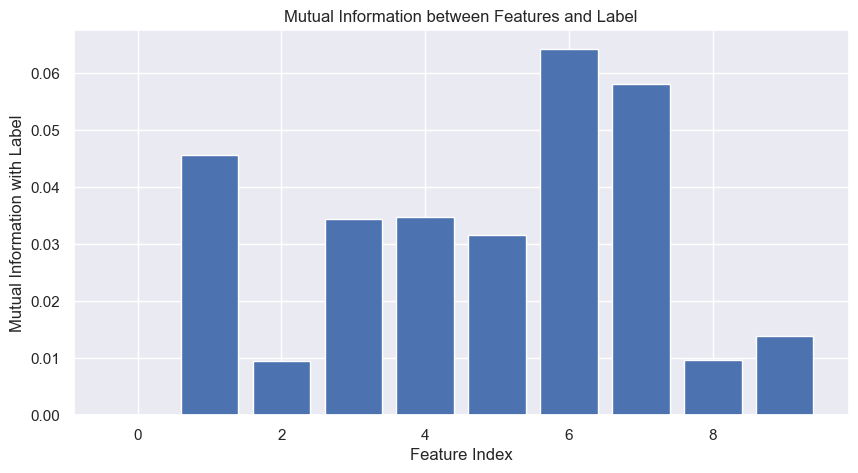

In [10]:
plt.figure(figsize=(10, 5))
plt.bar(range(len(mutual_informations)), mutual_informations)
plt.xlabel('Feature Index')
plt.ylabel('Mutual Information with Label')
plt.title('Mutual Information between Features and Label')
plt.grid(True)
plt.show()

In [11]:
# Number of top features to select
top_n = 7

# Get indices of top mutual information features
top_features_indices = np.argsort(mutual_informations)[-top_n:]

# Get the corresponding feature names
top_features_names = [feature_names[i] for i in top_features_indices]

print("Top features based on mutual information:")
for idx in np.flip(top_features_indices):
    print(f"Feature index: {idx}, Feature name: {feature_names[idx]}, Mutual Information: {mutual_informations[idx]:.4f}")



Top features based on mutual information:
Feature index: 6, Feature name: act_lh_free-library, Mutual Information: 0.0643
Feature index: 7, Feature name: act_lh_get-function-address, Mutual Information: 0.0581
Feature index: 1, Feature name: act_adbg_check-for-remote-debugger, Mutual Information: 0.0457
Feature index: 4, Feature name: act_afh_read-from-file, Mutual Information: 0.0348
Feature index: 3, Feature name: act_afh_map-file-into-process, Mutual Information: 0.0344
Feature index: 5, Feature name: act_afh_write-to-file, Mutual Information: 0.0316
Feature index: 9, Feature name: act_ph_enumerate-processes, Mutual Information: 0.0139
